In [227]:
# IMPORT HANDLER

import os
import os.path

import cedalion
import cedalion.nirs
import cedalion.xrutils
import cedalion.xrutils as xrutils
from cedalion.datasets import get_fingertapping_snirf_path
from cedalion.dataclasses import PointType
import cedalion.plots

import numpy as np
import pandas as pd
import xarray as xr
import pint
import pyxdf
import pyvista as pv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
import scipy.signal
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy.signal import correlate

xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)
pv.set_jupyter_backend('server')

import sys
if '..' not in sys.path:
    sys.path.append('./../')

from data_loader import load_data
from data_loader import *
from headmodel import build_headmodel

from fnirs_preprocessing import prune_fnirs_channels
from utils_plots import plot_sci_psp_quality, plot_time_series

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
def transform_markers_data(markers_data):
    """
    Transform markers_data DataFrame (either button presses or PP markers) to events format with onset, duration, value, and trial_type columns.
    
    Parameters:
    markers_data (pd.DataFrame): DataFrame with either:
        - 'marker' and 'time' columns, or
        - 'button', 'values', and 'time' columns
    
    Returns:
    pd.DataFrame: DataFrame with columns ['onset', 'duration', 'value', 'trial_type']
    """
    # Create a copy to avoid modifying the original data
    df = markers_data.copy()
    
    # Check which format the input data is in and standardize column names
    if 'marker' in df.columns:
        # Original format: marker, time
        marker_col = 'marker'
        value_col = None
    elif 'button' in df.columns:
        # New format: button, values, time
        marker_col = 'button'
        value_col = 'values'
    else:
        raise ValueError("DataFrame must contain either 'marker' or 'button' column")
    
    # Sort by time to ensure proper order
    df = df.sort_values('time').reset_index(drop=True)
    
    # Calculate duration as difference between current and next onset
    df['duration'] = df['time'].shift(-1) - df['time']
    
    # For the last row, duration will be NaN since there's no next marker
    # You might want to set this to 0 or some default value
    df['duration'] = df['duration'].fillna(0)
    
    # Create the output DataFrame
    result = pd.DataFrame({
        'onset': df['time'],
        'duration': df['duration'],
        'value': df[value_col] if value_col else 1,  # Use values column if available, otherwise 1
        'trial_type': df[marker_col]
    })
    
    return result


def sync_capnograph_to_lsl(rec, co2_xr, capnograph_trend_ds, 
                          smooth_size=100, peak_distance=250, 
                          show_plots=False):
    """
    Synchronize capnograph data with LSL timeline using cross-correlation of respiration signals.
    
    Parameters:
    -----------
    rec : Recording object
        SNIRF recording container with LSL data including 'respiration' in aux_ts
    co2_xr : xarray.DataArray
        CO2 waveform data with unix timestamps
    capnograph_trend_ds : xarray.Dataset
        Capnograph trend data with SpO2, PR, RR, and unix timestamps
    smooth_size : int, default=100
        Size of smoothing window for respiration signal
    peak_distance : int, default=250
        Minimum distance between peaks in samples (adjust based on sampling rate)
    show_plots : bool, default=False
        Whether to display diagnostic plots
        
    Returns:
    --------
    tuple of xarray.DataArray
        (co2_synced, spo2_synced, hr_synced, rr_synced) - all with LSL-relative timestamps
    """
    
    # Helper function to convert unix time to LSL relative time
    def sync_capno_to_lsl(capno_unix_time, lsl_start_unix):
        return capno_unix_time - lsl_start_unix
    
    # 1. Convert respiration belt signal to respiration rate
    print("Converting respiration belt signal to respiration rate...")
    resp_data = rec.aux_ts['respiration']
    resp_time = resp_data.time.values
    
    # Smooth the signal slightly
    smoothed_resp = uniform_filter1d(resp_data.values, size=smooth_size)
    
    # Find peaks (inhalations or exhalations depending on your signal polarity)
    peaks, _ = find_peaks(smoothed_resp, distance=peak_distance)
    
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in respiration signal. Try adjusting peak_distance parameter.")
    
    # Calculate instantaneous respiration rate
    peak_times = resp_time[peaks]
    breathing_intervals = np.diff(peak_times)
    breathing_rates = 60.0 / breathing_intervals  # Convert to breaths per minute
    
    # Interpolate to regular 1-second intervals to match capnograph
    resp_rate_time = np.arange(resp_time[0], resp_time[-1], 1.0)
    resp_rate_interp = np.interp(resp_rate_time, peak_times[1:], breathing_rates)
    
    # 2. Cross-correlation analysis
    print("Performing cross-correlation analysis...")
    
    # Get capnograph RR data
    capno_rr = capnograph_trend_ds.RR.values
    capno_time_unix = capnograph_trend_ds.time.values
    
    # Convert capnograph unix time to relative time (arbitrary reference)
    capno_time_rel = capno_time_unix - capno_time_unix[0]
    
    # Resample both signals to same sampling rate for correlation
    common_fs = 1.0
    max_duration = min(resp_rate_time[-1], capno_time_rel[-1])
    
    # Create common time base
    common_time = np.arange(0, max_duration, 1/common_fs)
    
    # Interpolate both signals to common time base
    resp_rate_common = np.interp(common_time, resp_rate_time, resp_rate_interp)
    capno_rr_common = np.interp(common_time, capno_time_rel, capno_rr)
    
    # Cross-correlation
    correlation = correlate(resp_rate_common, capno_rr_common, mode='full')
    lags = np.arange(-len(capno_rr_common) + 1, len(resp_rate_common))
    
    # Find the lag with maximum correlation
    max_corr_idx = np.argmax(correlation)
    optimal_lag = lags[max_corr_idx]
    max_correlation = correlation[max_corr_idx]
    
    print(f"Optimal time offset: {optimal_lag} seconds")
    print(f"Maximum correlation: {max_correlation:.3f}")
    
    # 3. Calculate the time offset to align capnograph with LSL timeline
    lsl_start_time_estimate = capno_time_unix[0] - optimal_lag
    
    # Apply synchronization to all capnograph xarrays
    print("Applying time synchronization...")
    co2_synced = co2_xr.assign_coords(time=sync_capno_to_lsl(co2_xr.time.values, lsl_start_time_estimate))
    spo2_synced = capnograph_trend_ds.SpO2.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    hr_synced = capnograph_trend_ds.PR.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    rr_synced = capnograph_trend_ds.RR.assign_coords(time=sync_capno_to_lsl(capnograph_trend_ds.time.values, lsl_start_time_estimate))
    
    # Optional visualization
    if show_plots:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # Plot 1: Raw respiration signal with detected peaks
        axes[0].plot(resp_time[:50000], resp_data.values[:50000], alpha=0.7, label='Raw Respiration')
        axes[0].plot(resp_time[:50000], smoothed_resp[:50000], label='Smoothed')
        peak_indices = peaks[peaks < 50000]  # Only peaks in the displayed range
        if len(peak_indices) > 0:
            axes[0].scatter(resp_time[peak_indices], smoothed_resp[peak_indices], 
                          color='red', s=50, label='Detected Peaks', zorder=3)
        axes[0].set_title('Peak Detection on Respiration Signal')
        axes[0].legend()
        axes[0].set_ylabel('Amplitude')
        
        # Plot 2: Cross-correlation function
        axes[1].plot(lags, correlation)
        axes[1].axvline(optimal_lag, color='red', linestyle='--', 
                       label=f'Optimal lag: {optimal_lag}s (corr={max_correlation:.3f})')
        axes[1].set_xlabel('Lag (seconds)')
        axes[1].set_ylabel('Correlation')
        axes[1].set_title('Cross-Correlation Function')
        axes[1].legend()
        
        # Plot 3: Synchronized respiration rates
        plot_duration = min(300, len(common_time))  # Show first 5 minutes or available data
        axes[2].plot(common_time[:plot_duration], resp_rate_common[:plot_duration], 
                    label='LSL Respiration Rate', alpha=0.8)
        
        # Apply shift for visualization
        capno_shifted_time = common_time + optimal_lag
        valid_indices = (capno_shifted_time >= 0) & (capno_shifted_time < resp_rate_time[-1])
        axes[2].plot(capno_shifted_time[valid_indices][:plot_duration], 
                    capno_rr_common[valid_indices][:plot_duration], 
                    label='Capno RR (synchronized)', alpha=0.8)
        
        axes[2].set_xlabel('Time (seconds)')
        axes[2].set_ylabel('Respiration Rate (BrPM)')
        axes[2].set_title('Synchronized Respiration Rates')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    return co2_synced, spo2_synced, hr_synced, rr_synced

def filter_respiration_signal(respiration_data, filter_type='lowpass', 
                            low_freq=None, high_freq=2.0, 
                            filter_order=4, plot_response=False, method='butter'):
    """
    Apply filtering to respiration signal stored in xarray DataArray.
    
    Parameters:
    -----------
    respiration_data : xarray.DataArray
        Input respiration signal with time coordinate
    filter_type : str
        'lowpass', 'highpass', or 'bandpass'
    low_freq : float
        Low cutoff frequency in Hz (for bandpass/highpass)
    high_freq : float
        High cutoff frequency in Hz (for bandpass/lowpass)
    filter_order : int
        Order of the Butterworth filter
    plot_response : bool
        Whether to plot the filter frequency response
    method : str
        Filter design method ('butter', 'cheby1', 'ellip')
    
    Returns:
    --------
    filtered_signal : xarray.DataArray
        Filtered respiration signal
    """
    
    # Calculate sampling rate from time coordinate
    time_diff = np.diff(respiration_data.time.values)
    dt = np.mean(time_diff)  # Average time step
    fs = 1.0 / dt  # Sampling frequency
    
    print(f"Detected sampling rate: {fs:.2f} Hz")
    print(f"Signal duration: {respiration_data.time.values[-1]:.2f} seconds")
    print(f"Number of samples: {len(respiration_data)}")
    
    # Design filter with stability checks
    nyquist = fs / 2.0
    
    # For very high sampling rates, use lower order filters or SOS format
    if fs > 100:  # High sampling rate detected
        print(f"High sampling rate detected ({fs:.1f} Hz). Using SOS format for stability.")
        use_sos = True
        # Reduce filter order for very low frequencies
        if filter_type == 'bandpass' and low_freq is not None and low_freq < 1.0:
            filter_order = min(filter_order, 2)
            print(f"Reduced filter order to {filter_order} for stability with low cutoff frequency")
    else:
        use_sos = False
    
    if filter_type == 'lowpass':
        if high_freq >= nyquist:
            raise ValueError(f"Cutoff frequency ({high_freq} Hz) must be less than Nyquist frequency ({nyquist:.2f} Hz)")
        
        # Normalize frequency
        normalized_freq = high_freq / nyquist
        if use_sos:
            sos = signal.butter(filter_order, normalized_freq, btype='low', output='sos')
        else:
            b, a = signal.butter(filter_order, normalized_freq, btype='low')
        filter_desc = f"Low-pass filter (cutoff: {high_freq} Hz)"
        
    elif filter_type == 'highpass':
        if low_freq >= nyquist:
            raise ValueError(f"Cutoff frequency ({low_freq} Hz) must be less than Nyquist frequency ({nyquist:.2f} Hz)")
        
        normalized_freq = low_freq / nyquist
        if use_sos:
            sos = signal.butter(filter_order, normalized_freq, btype='high', output='sos')
        else:
            b, a = signal.butter(filter_order, normalized_freq, btype='high')
        filter_desc = f"High-pass filter (cutoff: {low_freq} Hz)"
        
    elif filter_type == 'bandpass':
        if low_freq is None or high_freq is None:
            raise ValueError("Both low_freq and high_freq must be specified for bandpass filter")
        if high_freq >= nyquist or low_freq >= nyquist:
            raise ValueError(f"Cutoff frequencies must be less than Nyquist frequency ({nyquist:.2f} Hz)")
        if low_freq >= high_freq:
            raise ValueError("Low frequency must be less than high frequency")
            
        normalized_freqs = [low_freq / nyquist, high_freq / nyquist]
        if use_sos:
            sos = signal.butter(filter_order, normalized_freqs, btype='band', output='sos')
        else:
            b, a = signal.butter(filter_order, normalized_freqs, btype='band')
        filter_desc = f"Band-pass filter ({low_freq}-{high_freq} Hz)"
    
    else:
        raise ValueError("filter_type must be 'lowpass', 'highpass', or 'bandpass'")
    
    print(f"Applying {filter_desc}")
    
    # Apply filter using filtfilt for zero-phase filtering
    try:
        if use_sos:
            filtered_values = signal.sosfiltfilt(sos, respiration_data.values)
        else:
            filtered_values = signal.filtfilt(b, a, respiration_data.values)
    except Exception as e:
        print(f"Filter failed with error: {e}")
        print("Trying with padtype='even' and padlen reduction...")
        # Try with different padding options
        padlen = min(respiration_data.size // 4, 1000)  # Reduce padding length
        if use_sos:
            filtered_values = signal.sosfiltfilt(sos, respiration_data.values, 
                                               padtype='even', padlen=padlen)
        else:
            filtered_values = signal.filtfilt(b, a, respiration_data.values, 
                                            padtype='even', padlen=padlen)
    
    # Create new xarray DataArray with filtered data
    filtered_signal = respiration_data.copy()
    filtered_signal.values = filtered_values
    
    # Add attributes to track filtering
    filtered_signal.attrs['filter_applied'] = filter_desc
    filtered_signal.attrs['filter_order'] = filter_order
    filtered_signal.attrs['sampling_rate_hz'] = fs
    
    # Plot frequency response if requested
    if plot_response:
        if use_sos:
            w, h = signal.sosfreqz(sos, fs=fs)
        else:
            w, h = signal.freqz(b, a, fs=fs)
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(w, 20 * np.log10(abs(h)))
        plt.title('Filter Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)
        plt.axvline(x=high_freq if filter_type in ['lowpass', 'bandpass'] else low_freq, 
                   color='r', linestyle='--', alpha=0.7, label='Cutoff')
        if filter_type == 'bandpass' and low_freq is not None:
            plt.axvline(x=low_freq, color='r', linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(w, np.angle(h))
        plt.title('Phase Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (radians)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return filtered_signal


def plot_respiration_co2_with_markers(respiration_data, co2_data, markers_df, 
                                     time_window=None, marker_types_to_show=None,
                                     figsize=(20, 10), show_marker_blocks=True):
    """
    Plot respiration and CO2 signals with marker onset lines and optional shaded blocks.
    
    Parameters:
    -----------
    respiration_data : xarray.DataArray
        Respiration signal data
    co2_data : xarray.DataArray  
        CO2 signal data
    markers_df : pandas.DataFrame
        DataFrame with columns: onset, duration, value, trial_type
    time_window : tuple or None
        (start_time, end_time) in seconds to zoom into specific period
    marker_types_to_show : list or None
        List of marker types to display (e.g., ['breath_hold', 'normal_breath'])
    figsize : tuple
        Figure size (width, height)
    show_marker_blocks : bool
        Whether to show shaded blocks for marker durations
    """
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Apply time window if specified
    if time_window is not None:
        start_time, end_time = time_window
        
        # Filter respiration data
        resp_mask = (respiration_data.time >= start_time) & (respiration_data.time <= end_time)
        resp_time = respiration_data.time[resp_mask]
        resp_values = respiration_data.values[resp_mask]
        
        # Filter CO2 data
        co2_mask = (co2_data.time >= start_time) & (co2_data.time <= end_time)
        co2_time = co2_data.time[co2_mask]
        co2_values = co2_data.values[co2_mask]
        
        # Filter markers
        markers_filtered = markers_df[
            (markers_df['onset'] >= start_time) & 
            (markers_df['onset'] <= end_time)
        ].copy()
        
        title_suffix = f" ({start_time:.1f}s - {end_time:.1f}s)"
    else:
        resp_time = respiration_data.time
        resp_values = respiration_data.values
        co2_time = co2_data.time
        co2_values = co2_data.values
        markers_filtered = markers_df.copy()
        title_suffix = ""
    
    # Plot respiration signal
    ax1.plot(resp_time, resp_values, 'b-', linewidth=0.8, alpha=0.8, label='Respiration')
    ax1.set_ylabel('Respiration Signal', fontsize=12)
    ax1.set_title(f'Respiration and CO2 Signals with Experimental Markers{title_suffix}', fontsize=14, pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')
    
    # Plot CO2 signal
    ax2.plot(co2_time, co2_values, 'r-', linewidth=1.2, alpha=0.8, label='CO2')
    ax2.set_ylabel('CO2 Level', fontsize=12)
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    
    # Define colors for different marker types
    marker_colors = {
        'breath_hold': '#FF6B6B',      # Red
        'normal_breath': '#4ECDC4',    # Teal
        'prep_bhb': '#45B7D1',         # Blue
        'bhb_interval': '#96CEB4',     # Light green
        'end_1': '#FFA07A',            # Light salmon
        'sitting_all_off': '#DDA0DD'    # Plum
    }
    
    # Filter markers by type if specified
    if marker_types_to_show is not None:
        markers_filtered = markers_filtered[markers_filtered['trial_type'].isin(marker_types_to_show)]
    
    # Add vertical lines and optional shaded blocks for markers
    for idx, row in markers_filtered.iterrows():
        onset = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']
        
        # Get color for this marker type
        color = marker_colors.get(trial_type, '#808080')  # Default gray
        
        # Add vertical lines at onset
        ax1.axvline(x=onset, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
        ax2.axvline(x=onset, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Add shaded blocks for duration if requested and duration > 0
        if show_marker_blocks and duration > 0:
            # Get y-limits for shading
            y1_min, y1_max = ax1.get_ylim()
            y2_min, y2_max = ax2.get_ylim()
            
            # Add shaded rectangles
            ax1.axvspan(onset, onset + duration, alpha=0.2, color=color)
            ax2.axvspan(onset, onset + duration, alpha=0.2, color=color)
    
    # Create legend for marker types
    unique_markers = markers_filtered['trial_type'].unique()
    legend_elements = []
    for marker_type in unique_markers:
        color = marker_colors.get(marker_type, '#808080')
        legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--', 
                                        linewidth=2, label=marker_type.replace('_', ' ').title()))
    
    if legend_elements:
        ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()
    




# Example usage:

# # 1. Plot the entire dataset with all markers
# print("Plotting entire dataset...")
# plot_respiration_co2_with_markers(respiration, co2, markers, figsize=(25, 12))

# # 2. Focus on first 300 seconds to see detail                 # MAIN FUNCTION!
# print("\nPlotting first 5 minutes for detail...")
# plot_respiration_co2_with_markers(
#     respiration, co2, markers,
#     time_window=(0, 300),
#     figsize=(20, 10)
# )

# # 3. Analyze specific breath hold periods
# print("\nAnalyzing individual breath hold periods...")
# analyze_breath_hold_periods(respiration, co2, markers, n_periods=3)

# # 4. Create a focused plot on just breath holds and normal breathing
# print("\nPlotting with only breath hold and normal breath markers...")
# plot_respiration_co2_with_markers(
#     respiration, co2, markers,
#     time_window=(20, 200),  # First few minutes
#     marker_types_to_show=['breath_hold', 'normal_breath'],
#     figsize=(18, 10)
# )

In [229]:
# DIRECTORY HANDLER

data_dir = '/Users/pavelsyarov/Desktop/pilot'
sub = 'de779'
lsl_dir = os.path.join(data_dir, f'{sub}/{sub}.xdf')
snirf_dir = "/Users/pavelsyarov/Desktop/pilot/de779/Aurora/2025-04-24_001.snirf"
capnograph_dir = os.path.join(data_dir, f'{sub}/Capnograph')
fnirs_landmarks_pos_dir = '/Users/pavelsyarov/Desktop/pilot/de779/Aurora/digpts.txt'  # From Aurora

In [230]:
# SNIRF LOADER

recordings = cedalion.io.read_snirf(snirf_dir)
rec = recordings[0]

In [231]:
 # XDF LOADER

fnirs_xr, fnirs_geo3d, electrodes_mne, liveamp_aux_xr, capnograph_trend_ds, co2_xr, pulse_time_xr, markers_data, button_press_data, aurora_acc_xr, first_marker_unix, first_marker_unix_ts = load_data(lsl_dir, capnograph_dir, fnirs_landmarks_pos_dir=None)

Setting t0(=0.0s) to 20s before first prep_bhb marker at timestamp: 797992.1152413717
Data retained from t0 onwards:
  fNIRS: 30319 samples
  LiveAmp: 2370550 samples
  Markers: 348 samples
  Buttons: 7150 samples
  UnixTime: 4719 samples
  Aurora Acc: 408064 samples
Creating RawArray with float64 data, n_channels=40, n_times=2370550
    Range : 1 ... 2370550 =      0.002 ...  4753.301 secs
Ready.


In [232]:
# ADD LSL AURORA AMP DATA TO SNIRF CONTAINER

rec.timeseries['amp_native'] = rec.timeseries.pop('amp')
rec.timeseries['amp'] = fnirs_xr

In [233]:
# ADD FNIRS AUXILIARIES

# Accelerometer
rec.aux_ts['ACCEL_X_1_native'] = rec.aux_ts.pop('ACCEL_X_1')
rec.aux_ts['ACCEL_Y_1_native'] = rec.aux_ts.pop('ACCEL_Y_1')
rec.aux_ts['ACCEL_Z_1_native'] = rec.aux_ts.pop('ACCEL_Z_1')
rec.aux_ts['GYRO_X_1_native'] = rec.aux_ts.pop('GYRO_X_1')
rec.aux_ts['GYRO_Y_1_native'] = rec.aux_ts.pop('GYRO_Y_1')
rec.aux_ts['GYRO_Z_1_native'] = rec.aux_ts.pop('GYRO_Z_1')

rec.aux_ts['acc_x'] = liveamp_aux_xr.sel(channel='ACC_X')
rec.aux_ts['acc_y'] = liveamp_aux_xr.sel(channel='ACC_Y')
rec.aux_ts['acc_z'] = liveamp_aux_xr.sel(channel='ACC_Z')

rec.aux_ts['aurora_acc'] = aurora_acc_xr


# Galvanic Skin Response
rec.aux_ts['gsr'] = liveamp_aux_xr.sel(channel='GSR')


# Respiration
rec.aux_ts['respiration'] = liveamp_aux_xr.sel(channel='Resp')


# Button press pandas dataframe
rec.aux_ts['button_press'] = transform_markers_data(button_press_data)


# Capnograph data
# co2_synced, spo2_synced, hr_synced, rr_synced = sync_capnograph_to_lsl(
#     rec, co2_xr, capnograph_trend_ds, show_plots=True
# )

# rec.aux_ts['CO2'] = co2_synced
# rec.aux_ts['SpO2'] = spo2_synced
# rec.aux_ts['heart_rate'] = hr_synced
# rec.aux_ts['respiration_rate'] = rr_synced

In [234]:
# ADD FNIRS STIM

# PsychoPy markers
rec.stim = transform_markers_data(markers_data)


In [235]:
print(rec)

<Recording |  timeseries: ['amp_native', 'amp'],  masks: [],  stim: ['prep_bhb', 'bhb_interval', 'breath_hold', 'normal_breath', 'sitting_instr', 'pre_sitting', 'sitting_all_on', 'sitting_all_off', 'sitting_middle_on', 'sitting_middle_off', 'sitting_thumb_on', 'sitting_thumb_off', 'sitting_pinkie_on', 'sitting_pinkie_off', 'sitting_index_on', 'sitting_index_off', 'post_sitting', 'after_sitting', 'walking_instr', 'pre_walking', 'walking_index_on', 'walking_index_off', 'walking_all_on', 'walking_all_off', 'walking_middle_on', 'walking_middle_off', 'walking_thumb_on', 'walking_thumb_off', 'walking_pinkie_on', 'walking_pinkie_off', 'post_walking', 'after_walking'],  aux_ts: ['ACCEL_X_1_native', 'ACCEL_Y_1_native', 'ACCEL_Z_1_native', 'GYRO_X_1_native', 'GYRO_Y_1_native', 'GYRO_Z_1_native', 'acc_x', 'acc_y', 'acc_z', 'aurora_acc', 'gsr', 'respiration', 'button_press'],  aux_obj: []>


In [236]:
respiration = rec.aux_ts['respiration']
respiration_filtered = filter_respiration_signal(respiration, 'lowpass', high_freq=2.0)

markers = rec.stim
respiration = respiration_filtered
co2 = co2_xr

Detected sampling rate: 498.72 Hz
Signal duration: 4753.30 seconds
Number of samples: 2370550
High sampling rate detected (498.7 Hz). Using SOS format for stability.
Applying Low-pass filter (cutoff: 2.0 Hz)



Plotting first 300s...


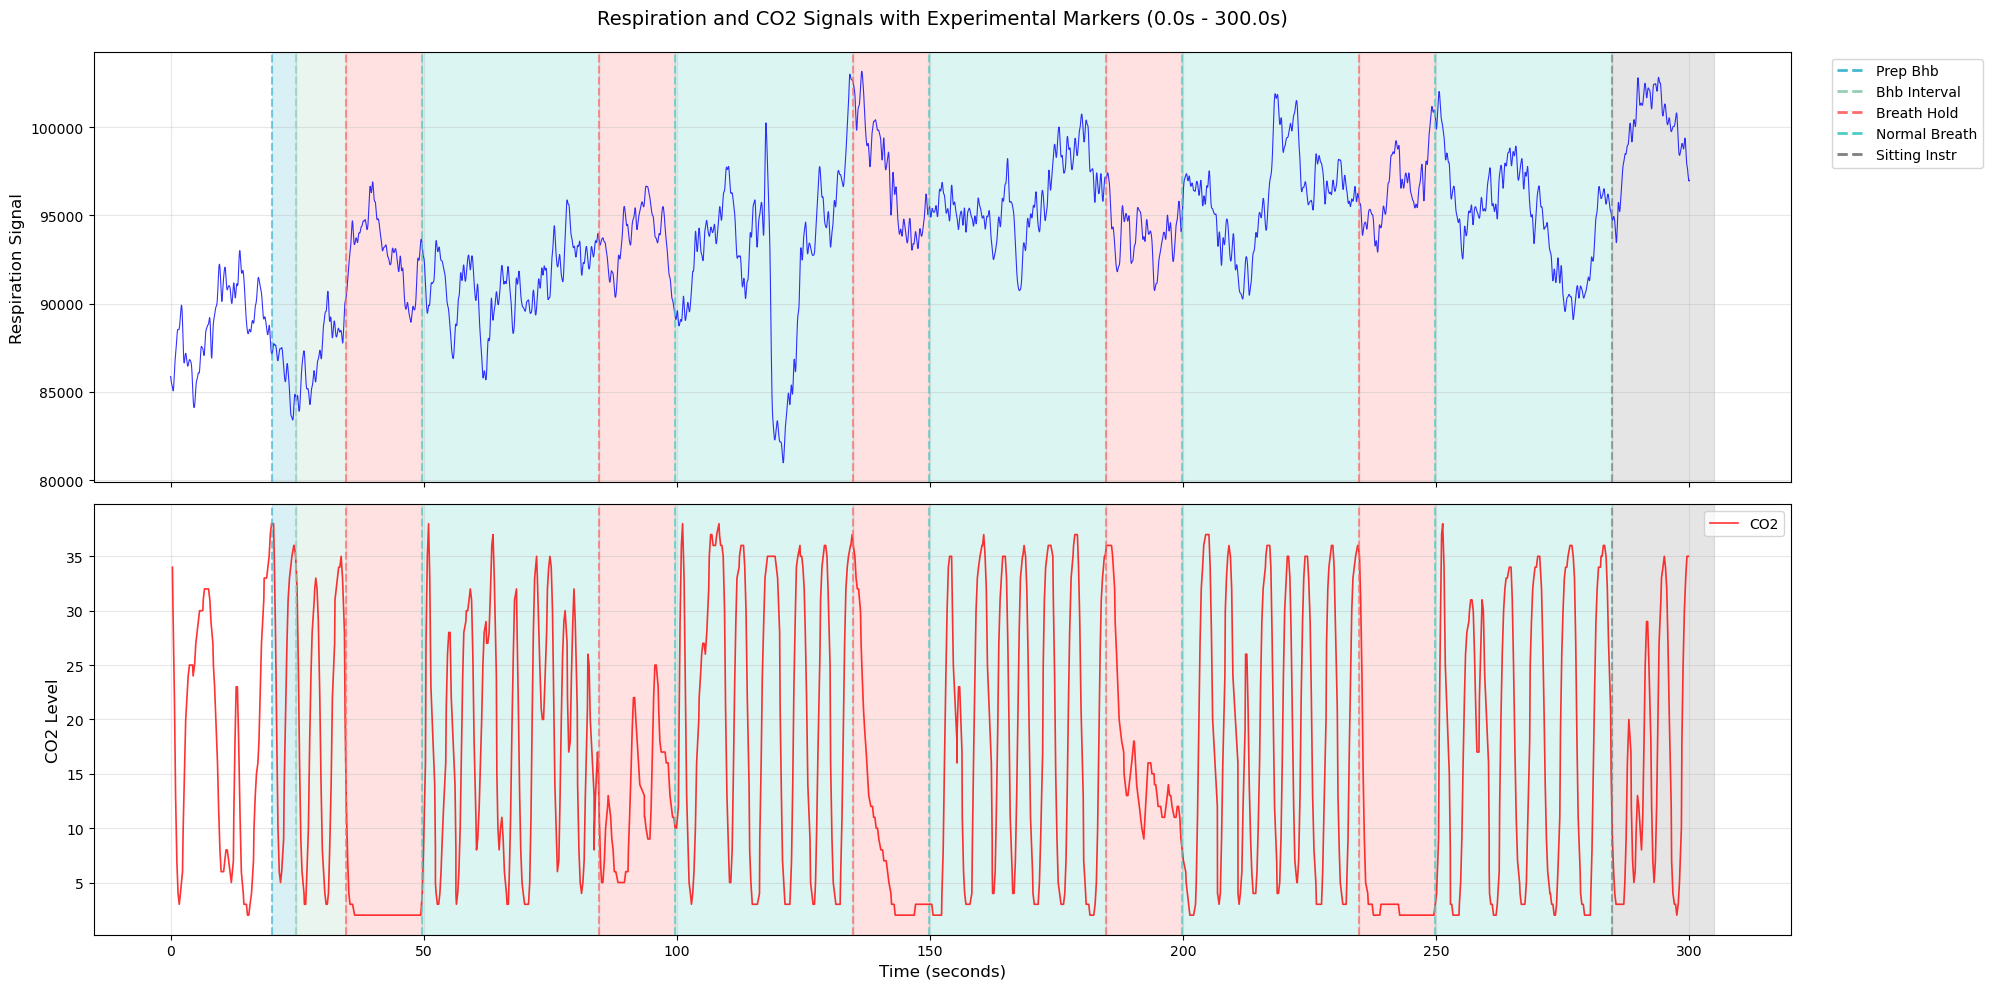

In [237]:
# 2. Focus on first ??? seconds to see detail                 # MAIN FUNCTION!
print("\nPlotting first 300s...")
plot_respiration_co2_with_markers(
    respiration, co2, markers,
    time_window=(0, 300),
    figsize=(20, 10)
)